In [1]:
import tensorflow as tf
import matplotlib.image as img
import numpy as np
from shutil import copytree, rmtree
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import requests
import tarfile
import os

def get_data_extract():
    if "flower_photos" in os.listdir():
        print("Dataset already exists")
    else:
        print("Downloading the data...")
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        file_path = 'flower_photos.tgz'
        response = requests.get(url, stream=True)
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)

        print("Dataset downloaded!")
        print("Extracting data..")
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall()
        print("Extraction done!")

def prepare_data(src, dest):
    print("Copying images from", src, "to", dest)
    if os.path.exists(dest):
        rmtree(dest)
    copytree(src, dest)
    print("Copying Done!")

In [2]:
# Загрузка данных
get_data_extract()

Dataset already exists


In [3]:
# Копирование данных без разделения на обучающий и тестовый наборы
print("Creating data folders without splitting")
prepare_data('C:\\python\\flower_photos', 'C:\\python\\flower_photo')

Creating data folders without splitting
Copying images from C:\python\flower_photos to C:\python\flower_photo
Copying Done!


In [4]:
num_obj = 5
img_width, img_height = 300, 300
data_dir = 'C:\\python\\flower_photo'  # Путь к папке с изображениями

batch_size = 16

data_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

data = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3670 images belonging to 5 classes.


In [11]:
# Загрузка предварительно обученной модели InceptionV3 без верхних слоев классификации
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_obj, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='C:/python/planets/best_model_epoch_{epoch:02d}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model.fit(
    data,
    steps_per_epoch=len(data),
    epochs=30,  # увеличим количество эпох до 30
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)
model.save('model_trained.hdf5')
current_directory = os.getcwd()
print(current_directory)

230/230 [==============================] - 318s 1s/step - loss: 1.3554 - accuracy: 0.4463
c:\python\planets


In [12]:
plants_list = ['rose', 'sunflower', 'dandelion', 'tulip', 'daisy']
images = [
    'C:\\python\\flower_photo\\oduvan.jpg',
    'C:\\python\\flower_photo\\podsolnuh.jpg',
    'C:\\python\\flower_photo\\romashka.jpg',
    'C:\\python\\flower_photo\\roza.jpg',
    'C:\\python\\flower_photo\\tulpan.jpg'
]

Файл не найден
c:\python\planets
['flower_photos', 'flower_photos.tgz', 'history.log', 'model_trained.hdf5', 'Plants.ipynb']
1/1 [==============================] - 3s 3s/step


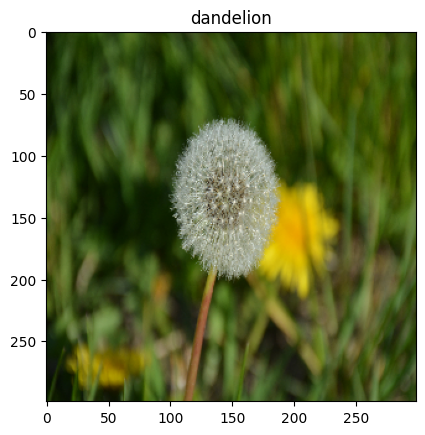

1/1 [==============================] - 0s 285ms/step


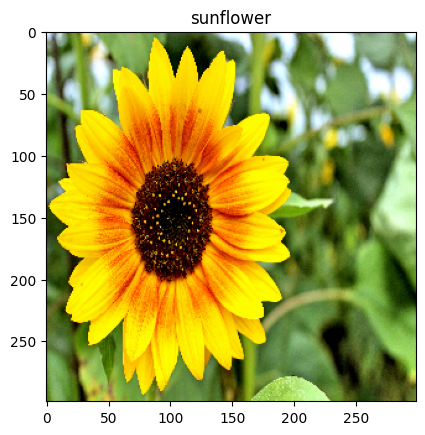

1/1 [==============================] - 0s 188ms/step


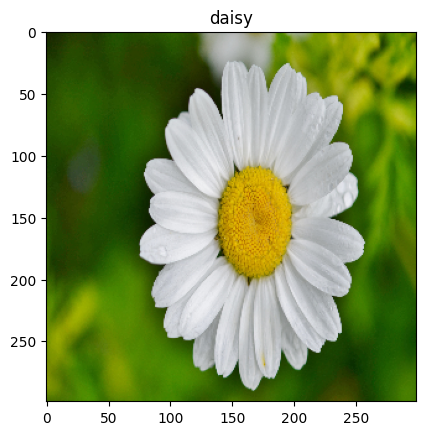

1/1 [==============================] - 0s 222ms/step


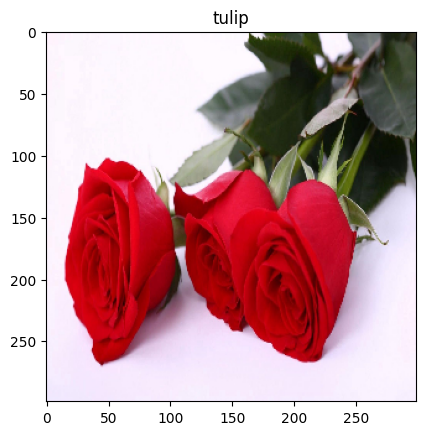

1/1 [==============================] - 0s 202ms/step


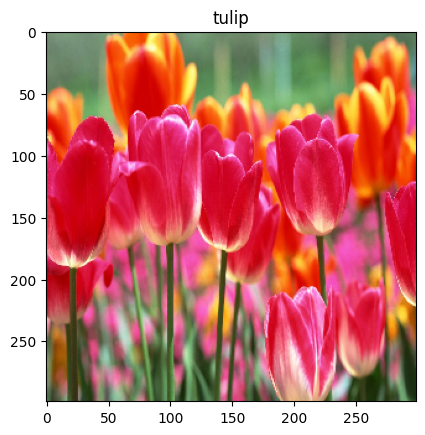

In [14]:
file_path = 'best_model_epoch_30.hdf5'
if os.path.exists(file_path):
    print("Файл существует")
else:
    print("Файл не найден")
current_directory = os.getcwd()
print(current_directory)

file_list = os.listdir(current_directory)
print(file_list)    
def predict_class(model, images, show=True):
    for img_path in images:
        img = image.load_img(img_path, target_size=(299, 299))
        img = image.img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255.                                      

        pred = model.predict(img)
        index = np.argmax(pred)
        plants_list.sort()
        pred_value = plants_list[index]
        if show:
            plt.imshow(img[0])                           
            plt.axis()
            plt.title(pred_value)
            plt.show()



# Загрузка лучшей модели
model_best = load_model('C:/python/planets/model_trained.hdf5', compile=False)
predict_class(model_best, images)